In [1]:
import urllib.request
import tarfile
import os
import torch
from PIL import Image
from torchvision import transforms
import zipfile
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [2]:
seed_value = 42

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
os.environ['PYTHONHASHSEED'] = str(seed_value)

# 2. Set `python` built-in pseudo-random generator at a fixed value
random.seed(seed_value)

# 3. Set `numpy` pseudo-random generator at a fixed value
np.random.seed(seed_value)

# 4. Set `torch` pseudo-random generator at a fixed value
torch.manual_seed(seed_value)

# 5. If you are using CUDA, set also the seed for it and enable deterministic behavior
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)  # if using multi-GPU.
    # Below two lines ensure deterministic behavior, but may lead to slower training
    # due to the need to find algorithms that have deterministic behavior.
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

NameError: name 'random' is not defined

In [ ]:
# Check if CUDA is available
# Regardless of whether or not you are using GPU create the no gpu environment for now
is_cuda_available = torch.cuda.is_available()

# Print the status of CUDA availability
print("CUDA Available:", is_cuda_available)

# Set the device to CUDA if available, otherwise use CPU
device = torch.device("cuda" if is_cuda_available else "cpu")

# Print the device being used
print("Using device:", device)

In [3]:
data_dir = "data"
aug_data_dir = "sbd_dat_mat"

In [4]:
# Uncomment to download train_val dataset, comment afterwards
# 
# os.makedirs(data_dir, exist_ok=True)
# 
# voc_url = "http://pjreddie.com/media/files/VOCtrainval_11-May-2012.tar"
# voc_name = "pascal_voc.tar"
# voc_name = os.path.join(data_dir, voc_name)
# 
# urllib.request.urlretrieve(voc_url, voc_name)
# 
# with tarfile.open(voc_name) as tar:
#     tar.extractall(path=data_dir)

In [5]:
# Augmentations dataset. This is a large dataset. Don't download unless you are planning on doing full training.
# aug_data_dir = "sbd_dat_mat"
# os.makedirs(aug_data_dir, exist_ok=True)
# 
# aug_url = "http://www.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/semantic_contours/benchmark.tgz"
# aug_name = os.path.join(aug_data_dir, 'sbd_aug.tar')
# 
# # Downloading the file from the URL
# urllib.request.urlretrieve(aug_url, aug_name)
# 
# with tarfile.open(aug_name) as tar:
#     tar.extractall(path=aug_data_dir)

In [48]:
from data_loader import pascalVOCLoader
from augmentations import *

# motivation for cropping instead of resizing: https://github.com/VainF/DeepLabV3Plus-Pytorch
aug_list = Compose([RandomCrop(512)])
pascal_original = os.path.join(data_dir, "VOCdevkit/VOC2012")
pascal_augment = os.path.join(aug_data_dir, "benchmark_RELEASE") # set this variable to None if you are not using the augmented (larger) dataset
train_dataset = pascalVOCLoader(pascal_original, pascal_augment, split="train_aug", is_transform=True, img_size='same', augmentations=aug_list)
val_dataset = pascalVOCLoader(pascal_original, pascal_augment, split='train_aug_val', is_transform=True, img_size='same', augmentations=aug_list)
# After this cell runs, switch to gpu environment if desired. Comment out dataset download code before running (above two cells).

In [49]:
from torch.utils.data import DataLoader

# DataLoader parameters
batch_size = 64  # You can adjust this depending on your GPU memory
shuffle = True   # Shuffles the dataset at every epoch
num_workers = 4  # Number of worker threads for loading data

# Create the DataLoaders for our training and validation sets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [50]:
vis_length = 5
imgs = []
masks = []
for img, mask in train_loader:
    imgs.append(train_dataset.unnormalize(img[0]))
    mask_decoded = train_dataset.decode_segmap(mask[0].numpy())
    masks.append(torch.tensor(mask_decoded).permute(2, 0, 1))
    if len(imgs) == vis_length:
        break
print(imgs[0].shape)
print(masks[0].shape)

torch.Size([3, 512, 512])
torch.Size([3, 512, 512])


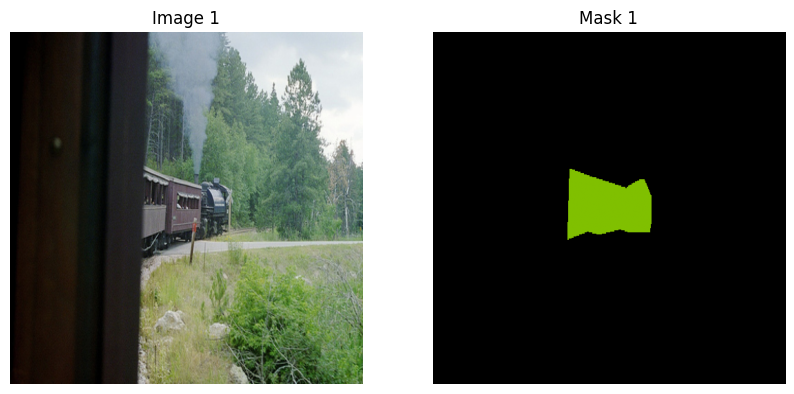

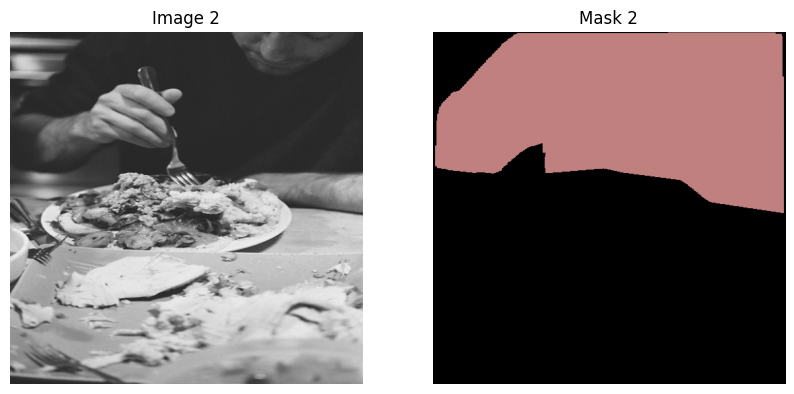

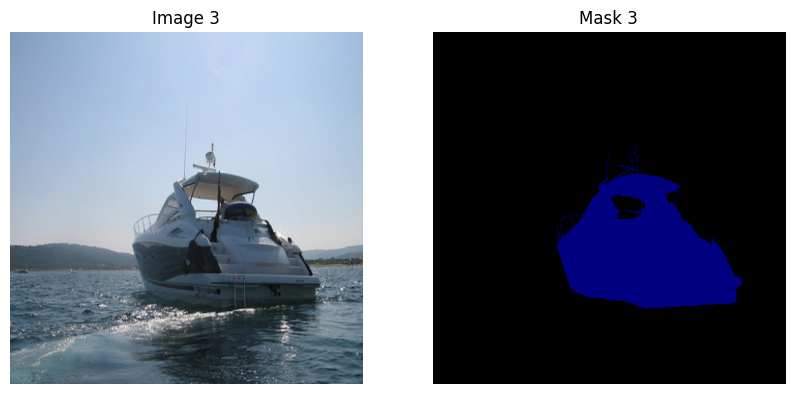

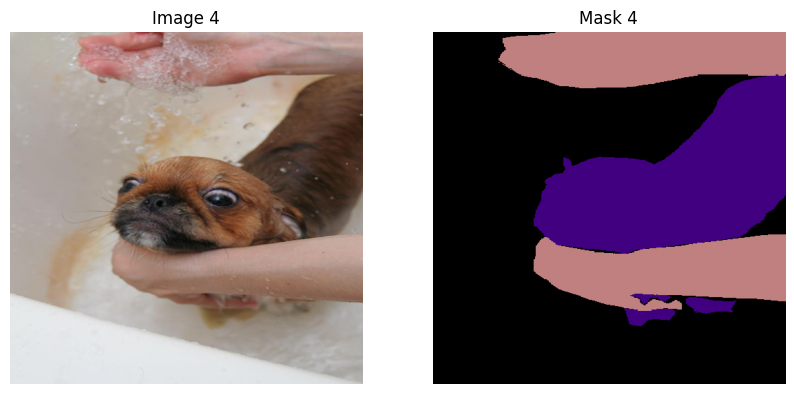

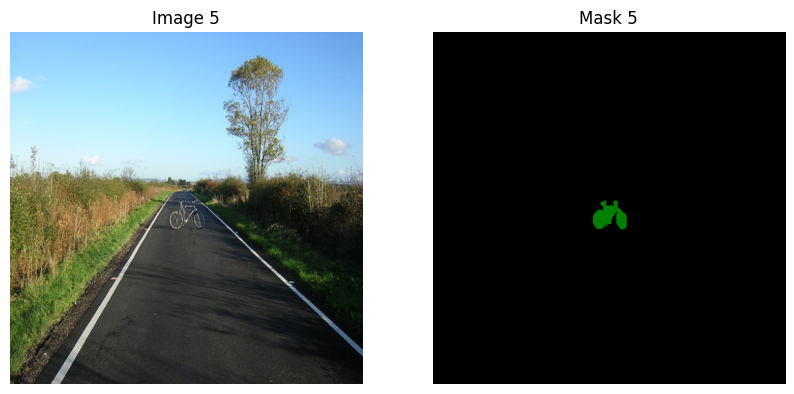

In [51]:
def visualize_image_and_mask_tensors(image_tensors, mask_tensors):
    """
    Visualize lists of image tensors and their corresponding mask tensors as regular images.
    
    Parameters:
        image_tensors (list of torch.Tensor): The list of image tensors to visualize.
        mask_tensors (list of torch.Tensor): The list of mask tensors to visualize.
    """
    for i, (image_tensor, mask_tensor) in enumerate(zip(image_tensors, mask_tensors)):
        # Convert the image tensor to numpy and change to HWC format for visualization
        image_np = image_tensor.permute(1, 2, 0).numpy()

        # Convert the mask tensor to numpy and change to HWC format for visualization
        mask_np = mask_tensor.permute(1, 2, 0).numpy()

        # Display the image and the mask side by side
        plt.figure(figsize=(10, 5))

        # Display the image
        plt.subplot(1, 2, 1)
        plt.imshow(image_np)
        plt.title(f'Image {i+1}')
        plt.axis('off')

        # Display the mask
        plt.subplot(1, 2, 2)
        plt.imshow(mask_np)
        plt.title(f'Mask {i+1}')
        plt.axis('off')

        plt.show()

# For testing, let's use the same image tensors and mask tensors as regular three-channel images
# We'll use the previously defined image_tensors and create new mask_tensors with 3 channels
mask_tensors = [torch.rand(3, 100, 100), torch.rand(3, 100, 100)]

# Test the function
visualize_image_and_mask_tensors(imgs, masks)